In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display, Image
import arviz
import pymc3

import dataloading
import models
import plotting

You are running the v4 development version of PyMC3 which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc3/tree/v3


### Fetch data and calibrations

In [3]:
df_layout = dataloading.get_layout()
df_A360 = dataloading.read_absorbances(dataloading.DP_DATA / "Placeholder_Absorbance_360nm.csv")
df_A600 = dataloading.read_absorbances(dataloading.DP_DATA / "Placeholder_Absorbance_600nm.csv")

reaction_wells = df_layout.loc[df_layout["product"].isna()].index
calibration_wells = df_layout.loc[~df_layout["product"].isna()].index

cm_600 = models.LinearBiomassAbsorbanceModel.load("calibration_A600.json")

### Construct the full model

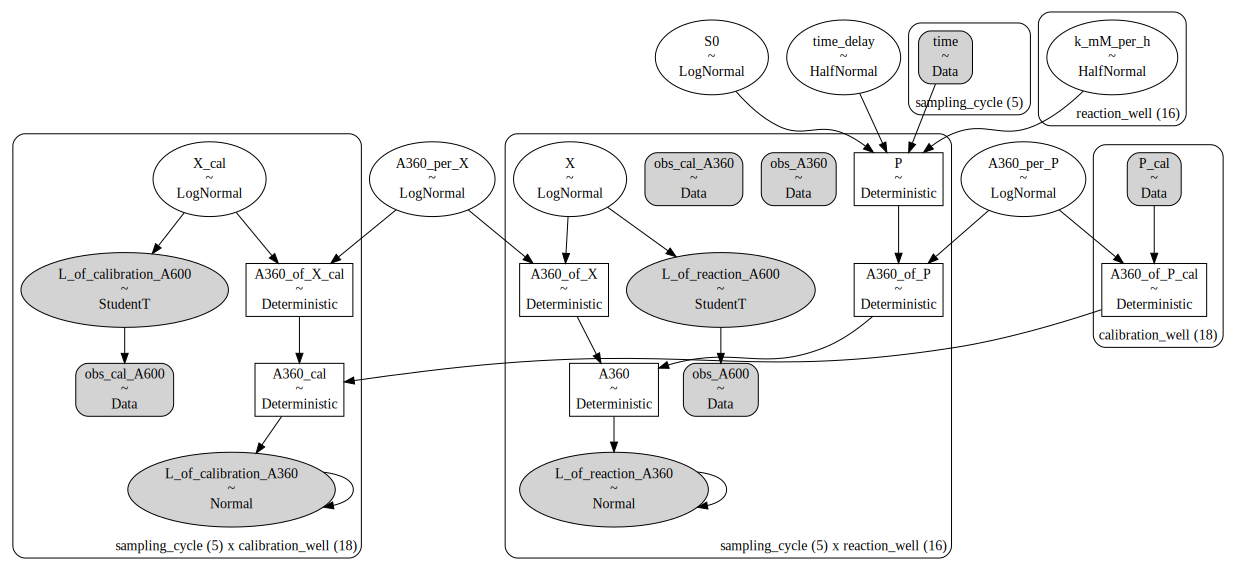

In [4]:
pmodel = models.build_model(
    df_layout,  # for mapping reaction and assay wells
    df_A360,    # raw measurements
    df_A600,    # raw measurements
    cm_600,     # for learning about X from A600
    kind="mass action",
)

# Optional: Plot the model in plate notation
pymc3.model_to_graphviz(pmodel)

### Hit the inference button!

In [5]:
with pmodel:
    idata = pymc3.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [X_cal, A360_per_X, A360_per_P, X, S0, time_delay, k_mM_per_h]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 30 seconds.


0, dim: sampling_cycle, 5 =? 5
1, dim: calibration_well, 18 =? 18
0, dim: sampling_cycle, 5 =? 5
1, dim: calibration_well, 18 =? 18
0, dim: sampling_cycle, 5 =? 5
1, dim: reaction_well, 16 =? 16
0, dim: sampling_cycle, 5 =? 5
1, dim: reaction_well, 16 =? 16


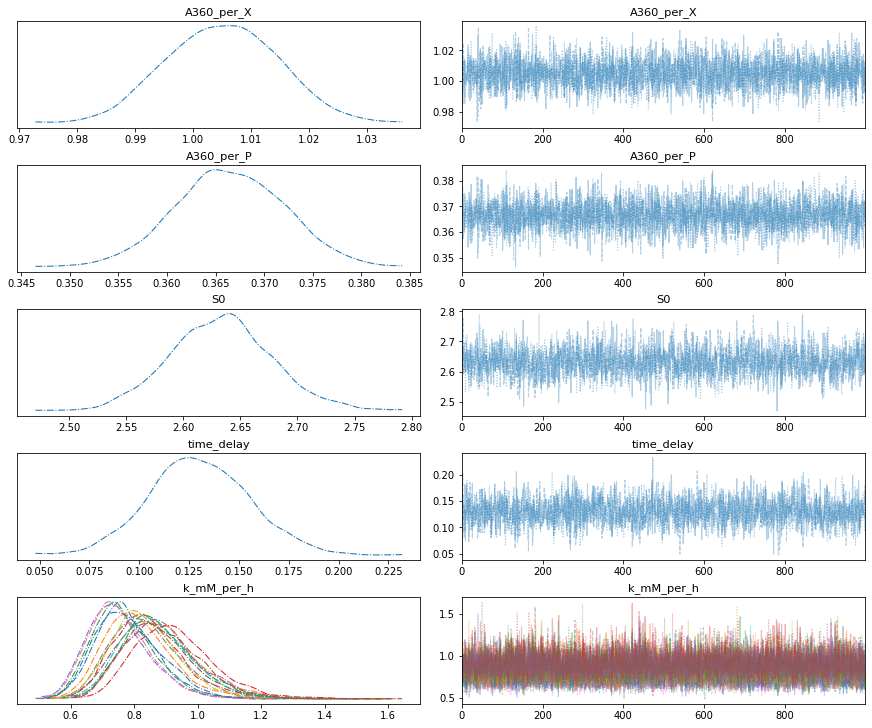

In [6]:
metric = "k_mM_per_h" if "k_mM_per_h" in idata.posterior else "vmax_mM_per_h"
interesting_variables = [
    "A360_per_X",
    "A360_per_P",
    "S0",
    "time_delay",
    metric
]
arviz.plot_trace(idata, var_names=interesting_variables, combined=True);

The plot shows the smallest interval in which the metric lies with a probability of 90.0 %.


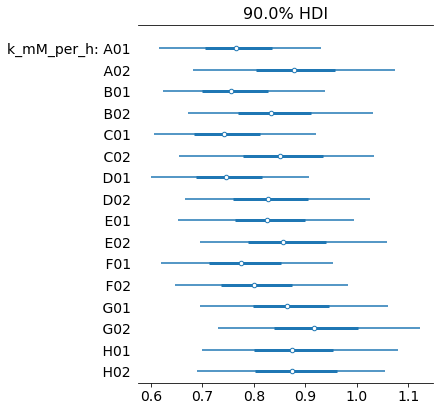

In [7]:
hdi_prob = 0.9
arviz.plot_forest(idata, var_names=metric, combined=True, hdi_prob=hdi_prob);
print(f"The plot shows the smallest interval in which the metric lies with a probability of {hdi_prob*100} %.")

In [8]:
arviz.summary(idata, var_names=interesting_variables, hdi_prob=hdi_prob)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A360_per_X,1.005,0.010,0.989,1.020,0.000,0.000,4134.0,2588.0,1.0
A360_per_P,0.366,0.006,0.357,0.376,0.000,0.000,4214.0,2898.0,1.0
S0,2.633,0.045,2.549,2.699,0.001,0.001,2349.0,2465.0,1.0
time_delay,0.130,0.025,0.090,0.173,0.000,0.000,2649.0,2482.0,1.0
k_mM_per_h[0],0.775,0.098,0.616,0.931,0.002,0.001,3712.0,2200.0,1.0
k_mM_per_h[1],0.891,0.125,0.682,1.075,0.002,0.002,3600.0,2197.0,1.0
k_mM_per_h[2],0.768,0.099,0.623,0.939,0.002,0.001,3571.0,2701.0,1.0
k_mM_per_h[3],0.847,0.115,0.673,1.032,0.002,0.001,3623.0,2184.0,1.0
k_mM_per_h[4],0.754,0.100,0.605,0.920,0.002,0.001,3703.0,2265.0,1.0
k_mM_per_h[5],0.863,0.120,0.653,1.034,0.002,0.001,3624.0,2505.0,1.0


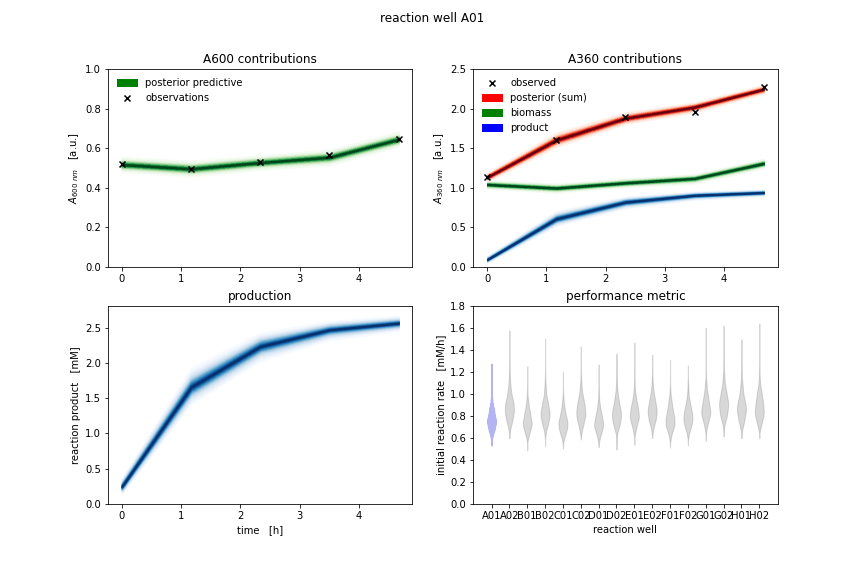

In [9]:
fp_out = plotting.plot_gif(
    fn_plot=lambda rwell: plotting.plot_reaction_well(idata, rwell, cm_600=cm_600),
    fp_out="reaction_results.gif",
    data=idata.posterior.reaction_well.values,
    fps=1.5
)
Image(fp_out)

In [11]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Oct 03 2021

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.22.0

arviz: 0.11.2
pymc3: 4.0

Watermark: 2.2.0

